Parsed 377 NSL letters
Processing NSL requests from FISA
Processing Issued NSL
Processing ROIs
[732085, 733770, 733770, 733815, 733832, 733832, 733850, 733903, 733924, 733932]
[43906.0, 264375.0, 264375.0, 271500.0, 272979.0, 272979.0, 276879.0, 287342.0, 291339.0, 287729.0]
Use degree 1 polyfit
Use degree 1 polyfit
Use degree 1 polyfit


/tmp/ipykernel_45871/3704903830.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


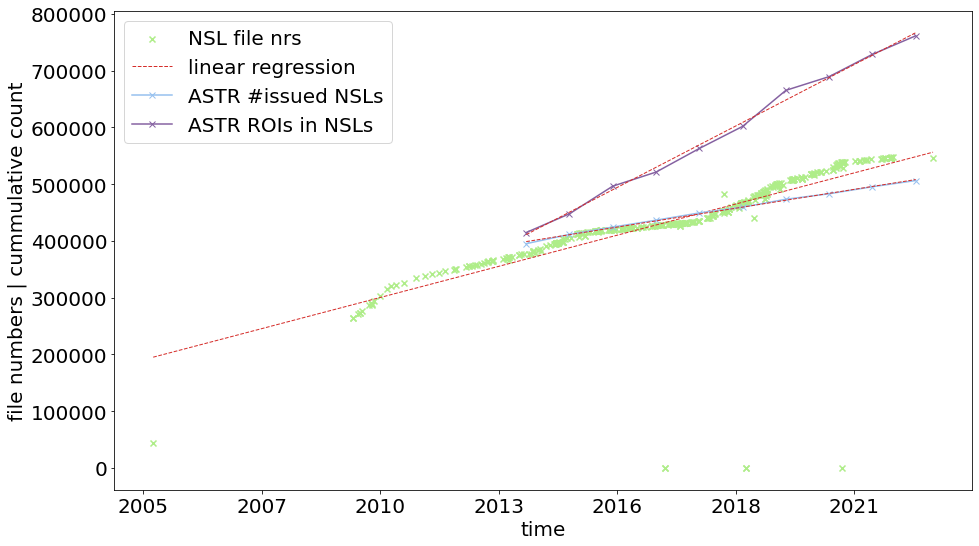

In [15]:
##### !!! TODO@Miro Explain 377908 !!! #####

# This file plots the file number of issued NSLs

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import os
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd

from nsl_class import NSL

# Optionally, truncate older (and very sparse) data
MIN_YEAR = None

# NSL data sources
NSL_CSV_FILE_PATHS = [
    "../../data/extracted/nsl_letters_google.csv",
    "../../data/extracted/nsl_letters_apple.csv",
    "../../data/extracted/nsl_letters_nslarchive.csv"
]

# Merge all CSVs into one pandas data frame
nsls_df = pd.concat(map(pd.read_csv, NSL_CSV_FILE_PATHS), ignore_index=True)

# Drop letters with unknown NSL number
nsls_df.dropna(subset=['file number'], inplace=True)

print(f"Parsed {len(nsls_df)} NSL letters")

public_available_nsls_x_axis_issue_date = []
public_available_nsls_y_axis_nsl_number = []
for nsl_index, nsl_row in nsls_df.iterrows():
    # If we use a cutoff, and this letter is outside of the used range, discard
    issue_date = NSL.parse_strftime(nsl_row['issue date'])
    if MIN_YEAR != None and issue_date.year < MIN_YEAR:
        continue

    public_available_nsls_x_axis_issue_date.append(issue_date)
    public_available_nsls_y_axis_nsl_number.append(NSL.parse_file_number(nsl_row['file number']))

fisa_nsls_us = {
    2005: 9254,
    2006: 12583,
    2007: 16804,
    2008: 24744,
    2009: 14788,
    2010: 24287,
    2011: 16511,
    2012: 15229,
    2013: 14219,
    2014: 12453,
    2015: 9418,
    2016: 8727,
    2017: 9006,
    2018: 11454,
    2019: 8557,
    2020: 6670,
    2021: 7607,
    2022: 8587
}

fisa_nsls_req_non_us = {
    2015: 31863,
    2016: 6651,
    2017: 14861,
    2018: 14481,
    2019: 35848,
    2020: 6187,
    2021: 9486,
    2022: 9103
}

fisa_nsls_req_sub = {
    2015: 7361,
    2016: 9432,
    2017: 17712,
    2018: 12937,
    2019: 19601,
    2020: 11368,
    2021: 14732,
    2022: 14927
}

nsls_issued = {
    2013: 19212,
    2014: 16348,
    2015: 12870,
    2016: 12150,
    2017: 12762,
    2018: 10235,
    2019: 13850,
    2020: 9682,
    2021: 12362,
    2022: 10941
}

rois = {
    2013: 38832,
    2014: 33024,
    2015: 48642,
    2016: 24801,
    2017: 41579,
    2018: 38872,
    2019: 63466,
    2020: 24225,
    2021: 39214,
    2022: 32617
}

def get_cumulative_nsls_over_years(data, base_number_of_nsls=0):
    # start with base_number_of_nsls if not 0
    x_axis_time = []
    y_axis_total_nsls = []
    total_number_of_nsls = base_number_of_nsls
    for year, number in data.items():
        total_number_of_nsls += number
        x_axis_time.append(datetime(year=year, month=12, day=31))
        y_axis_total_nsls.append(total_number_of_nsls)
    return x_axis_time, y_axis_total_nsls

print("Processing NSL requests from FISA")
fisa_nsls_req = {}
for year, number_of_nsls_that_year in fisa_nsls_us.items():
    if MIN_YEAR == None or year >= MIN_YEAR:
        fisa_nsls_req[year] = number_of_nsls_that_year + fisa_nsls_req_non_us.get(year, 0) + fisa_nsls_req_sub.get(year, 0)

print("Processing Issued NSL")
astr_nsls_issued_x_axis_time, astr_nsls_issued_y_axis_cumulative_number = get_cumulative_nsls_over_years(nsls_issued, 377908-next(iter(nsls_issued)))

print("Processing ROIs")
astr_rois_in_nsls_x_axis_time, astr_rois_in_nsls_y_axis_cumulative_number = get_cumulative_nsls_over_years(rois, 377908-next(iter(rois)))


#
# Plotting (following guidelines of MP)
#
plt.rc("axes", axisbelow=True)

plt.rcParams["font.size"] = 20
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["figure.figsize"] = (14,8)

colors = ["#afed89", "#ffc1cc", "#ebc197", "#95c0ef", "#8561a1", 
            "#edc895", "#2c7707", "#9c9ed1", "#ccab0a"]

def to_ordinal(xs):
    return list(map(lambda x: x.toordinal(), xs))

def poly_regression(xs, ys, deg=1):
    """
    Compute regression on xs, ys with polynomial of degree `deg`
    (for deg=1, this computes the linear regression)
    """                                                                                                                                                                                                        
    print(f"Use degree {deg} polyfit")
    x_vals = np.array(xs)
    coeffs = np.polyfit(xs, np.array(ys), deg=deg)
    new_xs = np.linspace(xs[0], xs[-1], len(x_vals))
    new_ys = []
    for x in new_xs:
        y = 0
        for i, coeff in enumerate(coeffs):
            y += x**(deg-i) * coeff
        new_ys.append(y)

    return new_xs, new_ys

def plot_regression(ax, xs, ys, deg=1, label=None):
    """
    Add a line with the polynomial regression of degree `deg` to axis `ax`
    """
    regression_xs, regression_ys = poly_regression(xs, ys)                                                                                                                                                               
    ax1.plot(regression_xs, regression_ys, linestyle="--", color="#d52d2a", label=label, linewidth=1)

# sort file numbers
public_available_nsls_x_axis_issue_date_ordinal = to_ordinal(public_available_nsls_x_axis_issue_date)
sorted_public_available_nsls_plotting_data = sorted(zip(public_available_nsls_x_axis_issue_date_ordinal, public_available_nsls_y_axis_nsl_number), key=lambda x: x[0])
public_available_nsls_x_axis_issue_date_sorted, public_available_nsls_y_axis_nsl_number_sorted = map(list, list(zip(*sorted_public_available_nsls_plotting_data)))
print(public_available_nsls_x_axis_issue_date_sorted[:10])
print(public_available_nsls_y_axis_nsl_number_sorted[:10])

# Plotting the numbers acquired from different sources
fig, ax1 = plt.subplots()

# nsl numbers from publicly available nsl files
plt.scatter(public_available_nsls_x_axis_issue_date_sorted, public_available_nsls_y_axis_nsl_number_sorted, color=colors[0], marker="x", label="NSL file nrs")
plot_regression(ax1, public_available_nsls_x_axis_issue_date_sorted, public_available_nsls_y_axis_nsl_number_sorted, label="linear regression")

# number reported in astar
plt.plot(to_ordinal(astr_nsls_issued_x_axis_time), astr_nsls_issued_y_axis_cumulative_number, colors[3], marker="x", label="ASTR #issued NSLs")
plot_regression(ax1, to_ordinal(astr_nsls_issued_x_axis_time), astr_nsls_issued_y_axis_cumulative_number)

# rois reported in astar
plt.plot(to_ordinal(astr_rois_in_nsls_x_axis_time), astr_rois_in_nsls_y_axis_cumulative_number, colors[4], marker="x", label="ASTR ROIs in NSLs")
plot_regression(ax1, to_ordinal(astr_rois_in_nsls_x_axis_time), astr_rois_in_nsls_y_axis_cumulative_number)


ax = plt.gca()
x_ticks = ax.get_xticks()

# set plot xticklabels
new_labels = [datetime.fromordinal(int(item)).year for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)

# Save
plt.xlabel("time")
plt.ylabel("file numbers | cummulative count")
plt.legend(loc="upper left")
plt.tight_layout()

OUTPUT_DATA_DIR = "../../data/processed/"
plt.savefig("{}/file_numbers.pdf".format(OUTPUT_DATA_DIR))
plt.savefig("{}/file_numbers.png".format(OUTPUT_DATA_DIR))